# Initial exploration

### Exploration

- use revenue / budget ratio as the response variable? or including an interaction term with budget?
- sampling procedure?
- check if 'release_date' is being treated as a numeric variable
- 'out of time validation'? (if there is a significant trend over time)
- do cross validation -> metric? use relative error? (accounting for smaller revenue movies?); e.g. error = ((pred - actual)/actual)^2
- for performance comparison; pick a baseline? e.g. revenue = c*budget
- random forest (shap value?)
- number of characters in the title as a feature?
- including other dataset? stock market data (S&P500)?
- release date -> cyclical pattern? add months? holidays?

## Transforming variables

### Genres

### spoken languages

### Release date

Do we want to transform this variable as well?

This data does not have 'production companies', 'keywords', 'cast'. Do we want those?

Also we can do some kind of dimension reduction such as PCA for genres and languages columns.

### Linear Regression

### Output plots

It seems that overall linear trend is present, but more complex model might be more reasonbale here.

## Loading the data

In [1]:
from collections import Counter
import tmdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_columns = None

In [3]:
dat = pd.read_pickle('movie_with_var.pkl')
cast_directors_pca = pd.read_pickle('pca.pkl')
dat = pd.concat([dat, cast_directors_pca], axis=1)
dat.shape

(6147, 93)

# Revenue Prediction
## Train & Test set split & Prediction performance

Target: Revenue ($)

In [4]:
# sort with release_date
dat = dat.sort_values('release_date').reset_index()
dat['budget'] = dat.budget.astype(float)
dat['popularity'] = dat.popularity.astype(float)
dat['runtime'] = dat.runtime.astype(float)
dat['video'] = dat.video.astype(float)
dat['vote_average'] = dat.vote_average.astype(float)
dat['vote_count'] = dat.vote_count.astype(float)
dat['revenue'] = dat.revenue.astype(float)

dat = dat.loc[dat['revenue'] > 0] # removing movies without revenue record
dat.shape

(5547, 94)

In [5]:
train = dat.iloc[0:4800,:] # 1902-04-17 ~ 2017-09-22
test = dat.iloc[4800:,:]   # 2017-09-22 ~ 2023-10-25
test.head()

,index,budget,original_language,original_title,overview,popularity,production_countries,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count,cast,directors,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Adventure,genre_Crime,genre_Romance,genre_Horror,genre_Science Fiction,genre_Fantasy,genre_Family,genre_Mystery,genre_Animation,genre_History,genre_War,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Italiano,language_Pусский,language_日本語,language_普通话,language_العربية,language_,language_Latin,language_广州话 / 廣州話,language_Português,language_한국어/조선말,language_svenska,language_हिन्दी,language_Polski,language_ภาษาไทย,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Český,language_Dansk,language_Tiếng Việt,language_Norsk,language_Magyar,language_Nederlands,language_Український,language_No Language,language_Română,collection,has_homepage,production,dates,production_countries_US,release_month,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,0,1,2,3,4,5,6,7,8,9
5267,2645,25000000.0,en,Battle of the Sexes,The true story of the 1973 tennis match betwee...,11.793,"[GB, US]",2017-09-22,12638526.0,121.0,Released,He made a bet. She made history.,Battle of the Sexes,0.0,6.775,1749.0,"[Emma Stone, Tom Kenny, Andrea Riseborough, St...","[Jonathan Dayton, Valerie Faris]",3,Comedy Drama History,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,"[Fox Searchlight Pictures, Decibel Films, Clou...",0.899788,True,month_09,False,False,False,False,False,False,False,False,True,False,False,False,-0.055697,-0.022235,0.077244,0.018693,-0.089097,0.119432,-0.073781,-0.066958,0.009080,-0.096672
5268,2060,30000000.0,en,Stronger,A victim of the Boston Marathon bombing in 201...,14.431,"[HK, US]",2017-09-22,8484418.0,119.0,Released,Strength Defines Us,Stronger,0.0,6.982,1391.0,"[Clancy Brown, Jake Gyllenhaal, Tatiana Maslan...",[David Gordon Green],1,Drama,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"[Lionsgate, Bold Films, Mandeville Films, Nine...",0.899788,True,month_09,False,False,False,False,False,False,False,False,True,False,False,False,-0.015436,-0.008012,-0.055473,-0.016294,0.006800,-0.029629,-0.027281,-0.017649,-0.005816,0.003604
5269,1026,38000000.0,en,Only the Brave,Members of the Granite Mountain Hotshots battl...,27.768,[US],2017-09-22,25754775.0,133.0,Released,"It’s not what stands in front of you, it’s who...",Only the Brave,0.0,7.396,1429.0,"[Jennifer Connelly, Miles Teller, Josh Brolin,...",[Joseph Kosinski],2,Action Drama,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,"[di Bonaventura Pictures, Black Label Media, C...",0.899788,True,month_09,False,False,False,False,False,False,False,False,True,False,False,False,-0.025236,-0.002212,-0.068026,-0.028167,-0.045636,0.039163,0.021912,-0.018656,0.070615,-0.081907
5272,6013,6200000.0,en,Jeepers Creepers 3,Taking place on the last day of the Creeper’s ...,38.820,[US],2017-09-26,4017852.0,100.0,Released,Third Time's the Charm,Jeepers Creepers 3,0.0,4.900,824.0,"[Gina Philips, Meg Foster, Stan Shaw, Don Yess...",[Victor Salva],3,Horror Mystery Thriller,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True,"[Scoundrel Media, Myriad Pictures, Infinity Fi...",0.899968,True,month_09,False,False,False,False,False,False,False,False,True,False,False,False,-0.010865,-0.001380,-0.054412,-0.022010,-0.055769,-0.009656,0.015708,-0.000755,0.015347,-0.039921
5273,5457,19000000.0,en,Flatliners,"Five medical students, hoping to understand th...",19.939,[US],2017-09-28,45158254.0,111.0,Released,You haven't lived until you've died,Flatliners,0.0,5.673,2157.0,"[Kiersey Clemons, Nina Dobrev, Elliot Page, Ki...",[Niels Arden Oplev],3,Drama Hor

In [6]:
X_train = train.drop(['index', 'revenue', 'original_language', 'original_title', 'overview', 'production_countries', 'release_date', 'release_month', 'status',
                     'tagline', 'title', 'cast', 'directors', 'all_genres', 'production'], axis = 1)
y_train = train['revenue'] # /train['budget']
X_test = test.drop(['index', 'revenue', 'original_language', 'original_title', 'overview', 'production_countries', 'release_date', 'release_month', 'status',
                     'tagline', 'title', 'cast', 'directors', 'all_genres', 'production'], axis = 1)
y_test = test['revenue'] # /train['budget']

## XGBoost

### Time series K-fold CV (K=5)
* fold 1 : training [1], test [2]
* fold 2 : training [1 2], test [3]
* fold 3 : training [1 2 3], test [4]
* fold 4 : training [1 2 3 4], test [5]
* fold 5 : training [1 2 3 4 5], test [6]

## Parameter Tuning

## Final Fitting

### Variance Importance

### Example prediction

# Log Revenue Prediction
## Train & Test set split & Prediction performance

In [7]:
# dat['log_budget'] = np.log(dat['budget'] + 1)
dat['log_revenue'] = np.log(dat['revenue'] + 1)

train = dat.iloc[0:4800,:] # 1902-04-17 ~ 2017-09-22
test = dat.iloc[4800:,:]   # 2017-09-22 ~ 2023-10-25

X_train = train.drop(['index', 'revenue', 'log_revenue', 'original_language', 'original_title', 'overview', 'production_countries', 'release_date', 'release_month', 'status',
                     'tagline', 'title', 'cast', 'directors', 'all_genres', 'production'], axis = 1)
y_train = train['log_revenue'] # /train['budget']
X_test = test.drop(['index', 'revenue', 'log_revenue', 'original_language', 'original_title', 'overview', 'production_countries', 'release_date', 'release_month', 'status',
                     'tagline', 'title', 'cast', 'directors', 'all_genres', 'production'], axis = 1)
y_test = test['log_revenue'] # /train['budget']

In [72]:
train.tail()

,index,budget,original_language,original_title,overview,popularity,production_countries,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count,cast,directors,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Adventure,genre_Crime,genre_Romance,genre_Horror,genre_Science Fiction,genre_Fantasy,genre_Family,genre_Mystery,genre_Animation,genre_History,genre_War,num_languages,language_English,language_Français,language_Español,language_Deutsch,language_Italiano,language_Pусский,language_日本語,language_普通话,language_العربية,language_,language_Latin,language_广州话 / 廣州話,language_Português,language_한국어/조선말,language_svenska,language_हिन्दी,language_Polski,language_ภาษาไทย,language_עִבְרִית,language_ελληνικά,language_Türkçe,language_Český,language_Dansk,language_Tiếng Việt,language_Norsk,language_Magyar,language_Nederlands,language_Український,language_No Language,language_Română,collection,has_homepage,production,dates,production_countries_US,release_month,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12,0,1,2,3,4,5,6,7,8,9,log_revenue
5262,773,3000000.0,fr,L'Insulte,After an emotional exchange between a Lebanese...,7.572,"[FR, LB]",2017-09-14,1001305.0,112.0,Released,Words change everything.,The Insult,0.0,7.509,434.0,"[Talal Jurdi, Kamel ElBasha, Christine Choueir...",[Ziad Doueiri],2,Crime Drama,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False,"[Ezekiel Films, Rouge International, Tessalit ...",0.899428,False,month_09,False,False,False,False,False,False,False,False,True,False,False,False,0.005754,-0.005806,-0.032988,-0.018898,-0.019377,-0.048490,0.008807,0.037646,-0.020733,0.047017,13.816816
5263,2380,5741614.0,no,Thelma,A college student starts to experience extreme...,14.939,"[DK, FR, NO, SE]",2017-09-15,1471656.0,116.0,Released,,Thelma,0.0,6.866,931.0,"[Eili Harboe, Ellen Dorrit Petersen, Lars Berg...",[Joachim Trier],3,Drama Mystery Thriller,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,False,False,"[Eurimages, Motlys, Le Pacte, Norsk Filminstit...",0.899473,False,month_09,False,False,False,False,False,False,False,False,True,False,False,False,0.006012,-0.006086,-0.034659,-0.019932,-0.020507,-0.051741,0.009431,0.040387,-0.022135,0.050454,14.201900
5264,2101,104000000.0,en,Kingsman: The Golden Circle,When an attack on the Kingsman headquarters ta...,63.520,"[GB, US]",2017-09-20,410902662.0,141.0,Released,Reports of my death have been greatly exaggera...,Kingsman: The Golden Circle,0.0,6.970,9643.0,"[Pedro Pascal, Channing Tatum, Bruce Greenwood...",[Matthew Vaughn],3,Action Adventure Comedy,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True,"[20th Century Fox, Marv Films, Cloudy Producti...",0.899698,True,month_09,False,False,False,False,False,False,False,False,True,False,False,False,-0.026673,-0.017135,-0.091638,-0.023513,0.219093,-0.028858,0.017557,-0.021839,-0.009267,-0.057980,19.833867
5265,3465,70000000.0,en,The Lego Ninjago Movie,Six young ninjas are tasked with defending the...,27.359,"[AU, DK, US]",2017-09-21,123081555.0,101.0,Released,Find your inner piece.,The Lego Ninjago Movie,0.0,6.510,934.0,"[Jackie Chan, Bobby Lee, Olivia Munn, Constanc...","[Paul Fisher, Charlie Bean, Bob Logan]",5,Action Adventure Animation Comedy Family,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,"[Lin Pictures, Lord Miller, Vertigo Entertainm...",0.899743,True,month_09,False,False,False,False,False,False,False,False,True,False,False,False,-0.030072,-0.017413,-0.008049,0.001176,-0.048396,0.095702,0.030492,-0.021871,-0.015536,-0.113998,18.628358
5266,1726,15000000.0,ru,Салют-7,"USSR, June 1985. After contact with the Salyut...",15.080,[RU],2017-09-22,13767037.0,106.0,Released,,Salyut-7,0.0,7.113,419.0,"[Lyubov Aksyonova, Mariya Miro

## Parameter Tuning

In [9]:
from sklearn.model_selection import KFold
k = 5
random_seed = 2023
fold = list(KFold(k, shuffle = True, random_state = random_seed).split(X_train))
verbose = False

In [70]:
print(fold[0][0].shape)
print(fold[0][1].shape)

(3840,)
(960,)


In [10]:
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import ParameterGrid
param_grid = {'max_depth': [1, 3, 5, 10, 30, 100],
              'learning_rate' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
              'n_estimators': [500, 1000, 2000]}
grid = ParameterGrid(param_grid)
rmse_total = []
start = datetime.now()
for params in grid:
    
#     start = datetime.now()
    rmse = []
    for i, (train_index, val_index) in enumerate(fold):
        trn_X = X_train.iloc[train_index]
        trn_y = y_train.iloc[train_index]
        val_X = X_train.iloc[val_index]
        val_y = y_train.iloc[val_index]

        xgb_reg = xgb.XGBRegressor(
            colsample_bytree=0.7,
            n_estimators = params['n_estimators'],
            max_depth = params['max_depth'],
            learning_rate = params['learning_rate'],
            min_child_weight=1.5,
            reg_alpha=0.75,
            reg_lambda=0.45,
            subsample=0.8,
            early_stopping_rounds = 100
        )
        xgb_reg.fit(trn_X, trn_y, 
#                     early_stopping_rounds = 100,
                    eval_set=[(val_X, val_y)],
                   verbose = False)

        # rmse_k = np.sqrt(np.mean(((np.array(val_y) - xgb_reg.predict(val_X))/val_X['budget'])**2)) # relative to budget
        # -> this makes the prediction for high budget movies very bad
        rmse_k = np.sqrt(np.mean((np.array(val_y) - xgb_reg.predict(val_X))**2)) # rmse of log revenue
        rmse.append(rmse_k)
    
    rmse_total.append(np.mean(rmse))
    print("n_estimators: " + str(params['n_estimators']) + 
          ", max_depth: " + str(params['max_depth']) + 
          ", learning_rate: " + str(params['learning_rate']) + 
          ", rmse: " + str(np.mean(rmse)))
    print(str(int((datetime.now()-start).seconds/60))+ 'm elapsed...')
    print("------------------------------------------------------")

n_estimators: 500, max_depth: 1, learning_rate: 0.001, rmse: 10.376518329629471
0m elapsed...
------------------------------------------------------
n_estimators: 1000, max_depth: 1, learning_rate: 0.001, rmse: 6.40198427800226
0m elapsed...
------------------------------------------------------
n_estimators: 2000, max_depth: 1, learning_rate: 0.001, rmse: 2.6854381992235714
1m elapsed...
------------------------------------------------------
n_estimators: 500, max_depth: 3, learning_rate: 0.001, rmse: 10.361742620289785
1m elapsed...
------------------------------------------------------
n_estimators: 1000, max_depth: 3, learning_rate: 0.001, rmse: 6.369529407026469
1m elapsed...
------------------------------------------------------
n_estimators: 2000, max_depth: 3, learning_rate: 0.001, rmse: 2.6079625504534643
2m elapsed...
------------------------------------------------------
n_estimators: 500, max_depth: 5, learning_rate: 0.001, rmse: 10.361050228331354
2m elapsed...
-----------

n_estimators: 1000, max_depth: 1, learning_rate: 0.05, rmse: 1.1539083509122368
65m elapsed...
------------------------------------------------------
n_estimators: 2000, max_depth: 1, learning_rate: 0.05, rmse: 1.153098607411097
66m elapsed...
------------------------------------------------------
n_estimators: 500, max_depth: 3, learning_rate: 0.05, rmse: 1.1263523447814323
66m elapsed...
------------------------------------------------------
n_estimators: 1000, max_depth: 3, learning_rate: 0.05, rmse: 1.1241297969809991
66m elapsed...
------------------------------------------------------
n_estimators: 2000, max_depth: 3, learning_rate: 0.05, rmse: 1.1241088907604815
66m elapsed...
------------------------------------------------------
n_estimators: 500, max_depth: 5, learning_rate: 0.05, rmse: 1.1191996144459813
66m elapsed...
------------------------------------------------------
n_estimators: 1000, max_depth: 5, learning_rate: 0.05, rmse: 1.1191996144459813
67m elapsed...
--------

In [11]:
grid[np.argmin(rmse_total)] # final hyperparameters

{'n_estimators': 2000, 'max_depth': 10, 'learning_rate': 0.005}

## Final Fitting

In [12]:
# split final train and validation set
X_trn = X_train.iloc[0:4000,:]
y_trn = y_train.iloc[0:4000]
X_val = X_train.iloc[4000:,:]
y_val = y_train.iloc[4000:]

In [13]:
xgb_reg = xgb.XGBRegressor(
    colsample_bytree=0.7,
    n_estimators = grid[np.argmin(rmse_total)]['n_estimators'],
    max_depth = grid[np.argmin(rmse_total)]['max_depth'],
    learning_rate = grid[np.argmin(rmse_total)]['learning_rate'],
    min_child_weight=1.5,
    reg_alpha=0.75,
    reg_lambda=0.45,
    subsample=0.8,
    early_stopping_rounds = 100
    )

xgb_reg.fit(X_train, y_train, 
            eval_set=[(X_val, y_val)],
            verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.005, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1.5, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [14]:
pred = xgb_reg.predict(X_test)
# print(np.sqrt(np.mean(((np.array(y_test) - xgb_reg.predict(X_test))/X_test['budget'])**2)))
print(np.sqrt(np.mean((np.array(y_test) - xgb_reg.predict(X_test))**2)))

1.311818914365939


In [15]:
print(np.sqrt(np.mean((np.array(y_test) - np.log(X_test['budget']+1))**2)))

1.655217393229664


### Variance Importance

<Axes: >

/Users/hyoinan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from current font.
  func(*args, **kwargs)
/Users/hyoinan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Matplotlib currently does not support Devanagari natively.
  func(*args, **kwargs)
/Users/hyoinan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  func(*args, **kwargs)
/Users/hyoinan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2344 (\N{DEVANAGARI LETTER NA}) missing from current font.
  func(*args, **kwargs)
/Users/hyoinan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 2381 (\N{DEVANAGARI SIGN VIRAMA}) missing from current font.
  func(*args, **kwargs)
/Users/hyoinan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/e

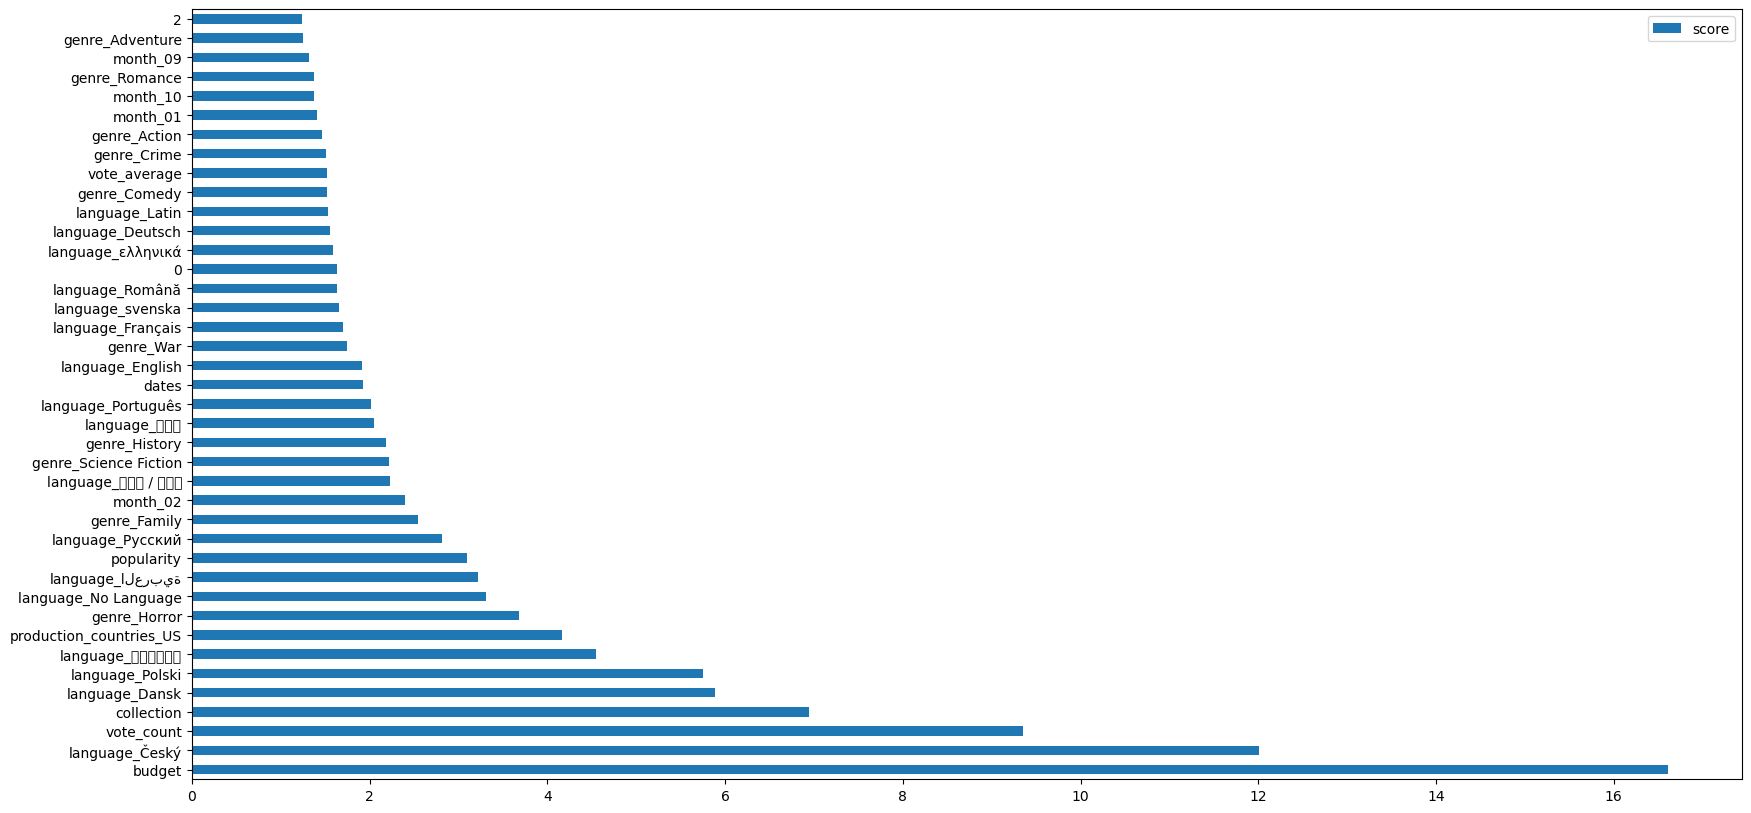

In [16]:
feature_important = xgb_reg.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

### Example prediction

In [17]:
pd.options.display.max_rows = 100
pd.DataFrame(np.column_stack((X_test['budget'], y_test, pred, y_test-pred)), columns = ['budget', 'log_Actual', 'Predicted', 'Difference'])

,budget,log_Actual,Predicted,Difference
0,25000000.0,16.352260,17.310478,-0.958218
1,30000000.0,15.953742,17.116859,-1.163117
2,38000000.0,17.064131,17.162113,-0.097983
3,6200000.0,15.206258,14.279436,0.926822
4,19000000.0,17.625684,17.034988,0.590695
...,...,...,...,...
742,80000000.0,18.440483,16.337683,2.102801
743,80000000.0,18.440483,16.337683,2.102801
744,30000000.0,18.696037,16.247324,2.448713
745,30000000.0,18.696037,16.247324,2.448713


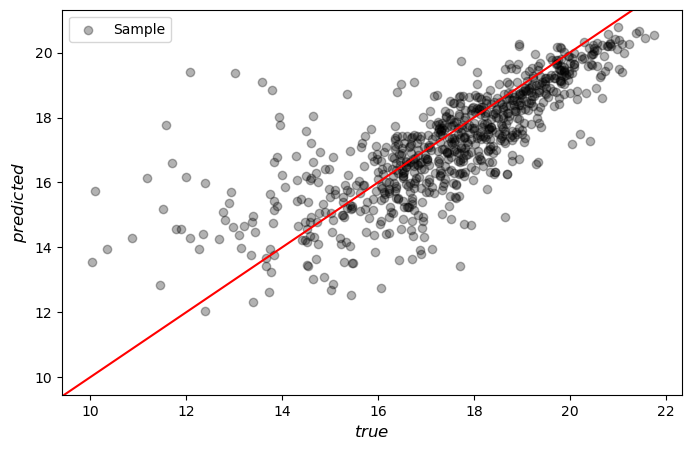

In [18]:
plt.figure(figsize=(8,5))

plt.scatter(y_test, 
            pred, 
            alpha=.3,
            label="Sample", color='black')
plt.legend(fontsize=10)
plt.xlabel("$true$", fontsize=12)
plt.ylabel("$predicted$", fontsize=12)
plt.axline([10, 10], [20, 20], color='red')
plt.show()

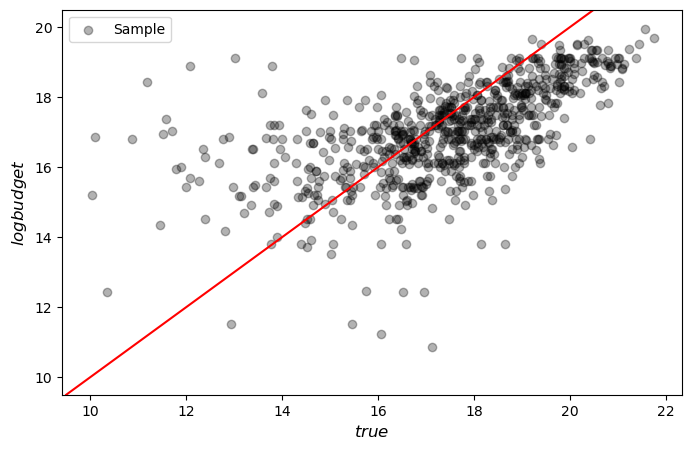

In [29]:
plt.figure(figsize=(8,5))

plt.scatter(y_test, 
            np.log(test['budget']+1), 
            alpha=.3,
            label="Sample", color='black')
plt.legend(fontsize=10)
plt.xlabel("$true$", fontsize=12)
plt.ylabel("$log budget$", fontsize=12)
plt.axline([10, 10], [20, 20], color='red')
plt.show()

In [19]:
test = test.reset_index(drop=True)
X_test = test.drop(['index', 'revenue', 'log_revenue', 'original_language', 'original_title', 'overview', 'production_countries', 'release_date', 'release_month', 'status',
                     'tagline', 'title', 'cast', 'directors', 'all_genres', 'production'], axis = 1)
y_test = test['log_revenue'] # /train['budget']

In [56]:
pd.options.display.max_rows = 8
result = pd.DataFrame(np.column_stack((np.exp(y_test)-1, np.round(np.exp(pred)-1), np.exp(y_test)-np.exp(pred))), columns = ['Actual', 'Predicted', 'Difference'])
result = pd.concat([test, result], axis = 1)

In [75]:
pd.options.display.max_rows = None
result_summary = result[['original_title', 'budget', 'Actual', 'Predicted', 'Difference']]

In [77]:
result_summary.sort_values(['Difference']).tail()

,original_title,budget,Actual,Predicted,Difference
698,The Super Mario Bros. Movie,100000000.0,1.355725e+09,296711904.0,1.059013e+09
110,Avengers: Infinity War,300000000.0,2.052415e+09,942065856.0,1.110349e+09
724,Barbie,145000000.0,1.441700e+09,263525792.0,1.178174e+09
674,Avatar: The Way of Water,460000000.0,2.320250e+09,752426752.0,1.567824e+09
280,Avengers: Endgame,356000000.0,2.800000e+09,824117184.0,1.975883e+09


In [87]:
result_summary.Difference.abs()

0      2.031069e+07
1      1.866482e+07
2      2.651288e+06
3      2.427549e+06
4      2.014320e+07
5      1.022610e+08
6      6.375957e+05
7      2.106458e+08
8      5.044452e+07
9      3.244085e+06
10     9.096239e+07
11     5.888212e+07
12     1.585995e+07
13     4.952171e+06
14     3.592729e+06
15     1.550357e+07
16     8.029645e+06
17     1.258337e+07
18     4.217853e+07
19     9.536297e+07
20     4.488816e+06
21     1.558733e+06
22     2.611968e+07
23     6.300464e+06
24     4.397874e+06
25     2.771255e+07
26     6.762211e+06
27     1.422279e+07
28     2.846571e+08
29     3.465470e+06
30     1.249240e+06
31     1.079263e+08
32     2.644540e+07
33     3.844758e+05
34     1.333096e+08
35     4.613030e+07
36     8.614860e+06
37     1.833663e+08
38     2.449992e+08
39     3.048028e+06
40     5.459812e+07
41     8.728563e+07
42     9.592131e+07
43     1.426676e+07
44     6.435916e+06
45     7.841794e+06
46     5.612570e+08
47     1.312302e+08
48     2.715240e+08
49     1.686697e+08


In [108]:
result_summary = result_summary.drop('Abs_Difference', axis=1)
result_summary.insert(5, 'Abs_Difference', result_summary.Difference.abs())

In [110]:
result_summary.sort_values('Abs_Difference')

,original_title,budget,Actual,Predicted,Difference,Abs_Difference
597,Ambulance,40000000.0,5.178304e+07,5.177158e+07,1.146100e+04,1.146100e+04
433,Capone,20600000.0,8.582810e+05,8.719040e+05,-1.362262e+04,1.362262e+04
637,After Ever Happy,14000000.0,1.920000e+07,1.916976e+07,3.024100e+04,3.024100e+04
461,The Wolf of Snow Hollow,2000000.0,2.398280e+05,1.716850e+05,6.814309e+04,6.814309e+04
366,Motherless Brooklyn,26000000.0,1.837774e+07,1.844846e+07,-7.072500e+04,7.072500e+04
509,Petite maman,3100000.0,1.024575e+06,9.478780e+05,7.669719e+04,7.669719e+04
411,The Last Full Measure,20000000.0,3.364426e+06,3.441710e+06,-7.728425e+04,7.728425e+04
364,L'uomo del labirinto,4000000.0,2.514679e+06,2.632423e+06,-1.177443e+05,1.177443e+05
145,The Miseducation of Cameron Post,900000.0,2.019874e+06,2.144494e+06,-1.246205e+05,1.246205e+05
545,The Many Saints of Newark,50000000.0,1.303740e+07,1.291098e+07,1.264260e+05,1.264260e+05


In [58]:
result['release_date'] = pd.to_datetime(result['release_date'])

<Axes: title={'center': 'Difference'}, xlabel='[Year]'>

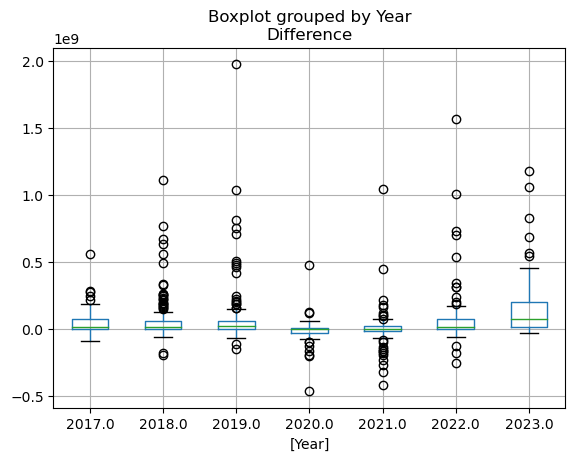

In [59]:
df = pd.DataFrame(np.column_stack((result['release_date'].dt.year, result['Difference'])), columns = ['Year', 'Difference'])
df.boxplot(by='Year')

<Axes: title={'center': 'Difference'}, xlabel='[Year]'>

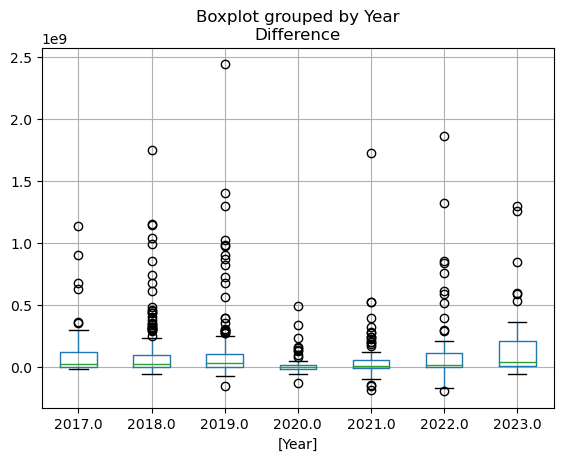

In [60]:
df = pd.DataFrame(np.column_stack((result['release_date'].dt.year, result['Actual']-result['budget'])), columns = ['Year', 'Difference'])
df.boxplot(by='Year')

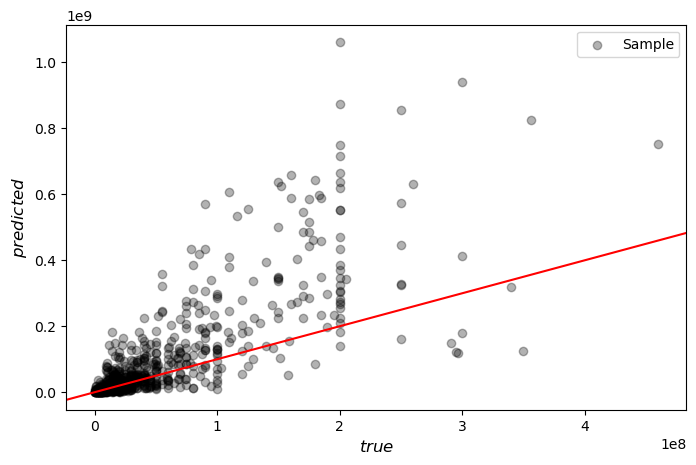

In [62]:
plt.figure(figsize=(8,5))

plt.scatter(test['budget'], 
            np.round(np.exp(pred)+1), 
            alpha=.3,
            label="Sample", color='black')
plt.legend(fontsize=10)
plt.xlabel("$true$", fontsize=12)
plt.ylabel("$predicted$", fontsize=12)
plt.axline([10, 10], [20, 20], color='red')
plt.show()

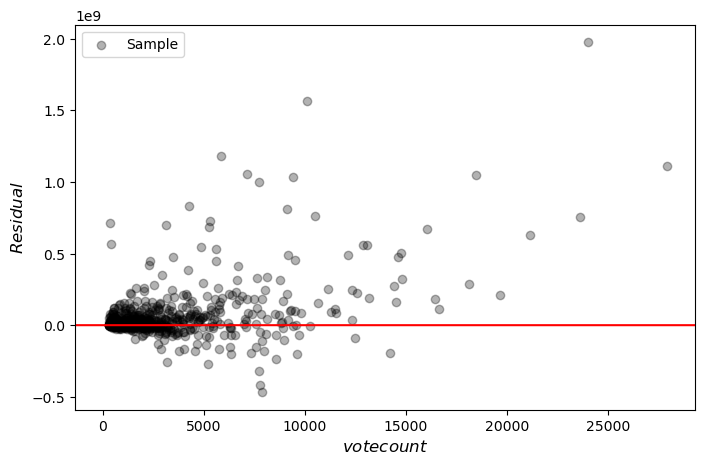

In [63]:
plt.figure(figsize=(8,5))

plt.scatter(result['vote_count'], 
            result['Difference'], 
            alpha=.3,
            label="Sample", color='black')
plt.legend(fontsize=10)
plt.xlabel("$vote count$", fontsize=12)
plt.ylabel("$Residual$", fontsize=12)
plt.axline([10, 10], [20, 20], color='red')
plt.show()

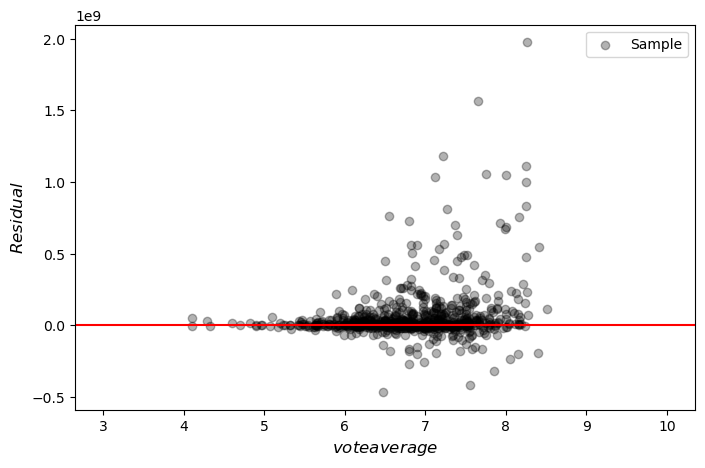

In [64]:
plt.figure(figsize=(8,5))

plt.scatter(result['vote_average'], 
            result['Difference'], 
            alpha=.3,
            label="Sample", color='black')
plt.legend(fontsize=10)
plt.xlabel("$vote average$", fontsize=12)
plt.ylabel("$Residual$", fontsize=12)
plt.axline([3, 3], [10, 10], color='red')
plt.show()

In [25]:
# from sklearn.model_selection import ParameterGrid
# param_grid = {'max_depth': [1, 3, 5, 10, 30, 50], 
#               'max_leaves': [10, 20, 30],
#               'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
#               'n_estimators': [100, 300, 500]}
# grid = ParameterGrid(param_grid)
# rmse_total = []
# start = datetime.now()
# for params in grid:
    
# #     start = datetime.now()
#     rmse = []
#     for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
#         trn_X = X_train.iloc[train_index]
#         trn_y = y_train.iloc[train_index]
#         val_X = X_train.iloc[val_index]
#         val_y = y_train.iloc[val_index]

#         xgb_reg = xgb.XGBRegressor(
#             n_estimators = params['n_estimators'],
#             max_depth = params['max_depth'],
#             max_leaves = params['max_leaves'],
#             learning_rate = params['learning_rate'],
#             early_stopping_rounds = 100
#         )
#         xgb_reg.fit(trn_X, trn_y, 
# #                     early_stopping_rounds = 100,
#                     eval_set=[(val_X, val_y)],
#                    verbose = False)

#         # rmse_k = np.sqrt(np.mean(((np.array(val_y) - xgb_reg.predict(val_X))/val_X['budget'])**2)) # relative to budget
#         # -> this makes the prediction for high budget movies very bad
#         rmse_k = np.sqrt(np.mean((np.array(val_y) - xgb_reg.predict(val_X))**2)) # rmse of log revenue
#         rmse.append(rmse_k)
    
#     rmse_total.append(np.mean(rmse))
#     print("n_estimators: " + str(params['n_estimators']) + 
#           "max_depth: " + str(params['max_depth']) + 
#           ", max_leaves: " + str(params['max_leaves']) +
#           ", learning_rate: " + str(params['learning_rate']) + 
#           ", rmse: " + str(np.mean(rmse)))
#     print(str(int((datetime.now()-start).seconds/60))+ 'm elapsed...')
#     print("------------------------------------------------------")

In [26]:
# import xgboost as xgb

# def xgb_model(trn_x, trn_y, val_x, val_y, verbose) :
    

    
#     record = dict()
#     model = xgb.train(params
#                       , xgb.DMatrix(trn_x, trn_y)
#                       , 100000
#                       , [(xgb.DMatrix(trn_x, trn_y), 'train'), (xgb.DMatrix(val_x, val_y), 'valid')]
#                       , verbose_eval=verbose
#                       , early_stopping_rounds=500)
    
#     # validation - calcuating relative rmse
#     val_pred = model.predict(xgb.DMatrix(val_x), ntree_limit=model.best_ntree_limit)
#     rmse = np.sqrt(np.mean(((val_pred - val_y)/val_x['budget'])^2))
    
    
#     best_idx = np.argmin(np.array(record['valid']['rmse']))


#     return {'val':val_pred, 'error':record['valid']['rmse'][best_idx], 'importance':[i for k, i in model.get_score().items()]}

In [27]:
# verbose = False
# random_seed = 2023
# for i, (train_index, val_index) in enumerate(tscv.split(X_train)):
#     trn_X = X_train.iloc[train_index]
#     trn_y = y_train.iloc[train_index]
#     val_X = X_train.iloc[val_index]
#     val_y = y_train.iloc[val_index]
    
#     start = datetime.now()
#     result = xgb_model(trn_X, trn_y, val_X, val_y, verbose)
#     fold_val_pred.append(result['val'])
#     fold_err.append(result['error'])
#     print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')

In [28]:
# from sklearn.model_selection import KFold
# k = 5
# random_seed = 2023
# fold = list(KFold(k, shuffle = True, random_state = random_seed).split(X_train))

# verbose = False
# for i, (trn, val) in enumerate(fold):
#     print(i+1, "fold.    RMSE")
    
#     X_tt = X_train.iloc[trn]
#     y_tt = y_train.iloc[trn]
#     X_val = X_train.iloc[val]
#     y_val = y_train.iloc[val]
    
#     fold_val_pred = []
#     fold_err = []
    
#     start = datetime.now()
#     result = xgb_model(X_tt, y_tt, X_val, y_val, verbose)
    
#     fold_val_pred.append(result['val'])
#     fold_err.append(result['error'])
    
#     print("xgb model.", "{0:.5f}".format(result['error']), '(' + str(int((datetime.now()-start).seconds/60)) + 'm)')